# Part 1: 資料讀取與基礎操作 (30 min)

這個 notebook 會介紹：

1. **Dask Client 設定**：如何啟動 Dask Dashboard 來監控計算過程
2. **Zarr vs NetCDF**：為什麼 Zarr 更適合大型 N-D array 處理
3. **intake-xarray**：如何使用 catalog 管理多個資料來源
4. **Lazy Evaluation**：Xarray + Dask 如何避免記憶體爆炸
5. **基礎操作**：選取、切片、檢視資料結構

---

## 學習目標

- 理解 Zarr 的優勢（平行讀取、雲端友善）
- 學會使用 intake catalog 組織資料
- 掌握 lazy evaluation 的概念和應用
- 透過 Dask Dashboard 觀察實際的計算過程

## 1. 環境設定與 Dask Client

### 為什麼需要 Dask Client？

Dask Client 提供兩大功能：
1. **Dashboard**：視覺化監控任務執行、記憶體使用、worker 狀態
2. **資源管理**：控制使用多少 CPU cores 和記憶體

### Dashboard 的重要性

在處理大型陣列時，我們需要知道：
- 哪些操作真的執行了？（Lazy vs Eager）
- 計算瓶頸在哪裡？（CPU-bound vs I/O-bound）
- 記憶體使用是否合理？

Dashboard 會在執行 `.compute()` 時顯示即時的任務圖 (task graph)。

In [1]:
import dask
from dask.distributed import Client
import xarray as xr
import intake
import numpy as np
import matplotlib.pyplot as plt

# 設定 Dask Client
# processes=False: 使用 threads (非 processes)，適合 I/O-bound 任務
# n_workers=2: 使用 2 個 workers，減少資源競爭
# memory_limit='2GB': 每個 worker 最多使用 2GB 記憶體
client = Client(processes=False, n_workers=2, threads_per_worker=2, memory_limit='2GB')

# 顯示 Dashboard 連結
print(f"Dask Dashboard: {client.dashboard_link}")
client

Dask Dashboard: http://127.0.0.1:8787/status


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44109,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45921,Total threads: 2
Dashboard: http://127.0.0.1:44459/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:44469,


### 如何使用 Dashboard？

1. **點擊上方的連結**開啟 Dashboard（通常是 `http://localhost:8787`）
2. **重要頁籤**：
   - **Status**: 總覽 CPU、記憶體、任務數
   - **Task Stream**: 看到每個 chunk 的處理時間線
   - **Graph**: 視覺化任務相依關係
   - **Progress**: 當前執行的進度

**實驗建議**：保持 Dashboard 開啟，後續執行 `.compute()` 時觀察變化。

## 2. Zarr vs NetCDF：為什麼選擇 Zarr？

### NetCDF 的限制

NetCDF（尤其是 NetCDF-4/HDF5）在氣象領域很常見，但有以下問題：

1. **平行讀取困難**
   - HDF5 的 metadata 集中在檔頭，平行讀取需要複雜的鎖機制
   - 多個 process 同時讀取容易衝突

2. **雲端不友善**
   - HDF5 假設低延遲的檔案系統（local disk）
   - 在 S3/GCS 上讀取效率很差（會產生大量小的 HTTP requests）

3. **單檔限制**
   - 通常一個 `.nc` 檔包含一個時間段，需要手動 `open_mfdataset()`

### Zarr 的優勢

Zarr 是專為雲端和平行運算設計的格式：

1. **天生支援平行讀取**
   - 每個 chunk 是獨立的檔案（或物件）
   - Metadata 分散儲存，無鎖競爭

2. **雲端優化**
   - 支援 object storage (S3, GCS, Azure Blob)
   - 透過 `consolidated metadata` 減少 HTTP requests

3. **目錄即資料集**
   - 一個 `.zarr` 目錄就是完整資料集
   - 可以用檔案系統或 object store 儲存

### 實際範例：檔案結構比較

```bash
# NetCDF: 單一檔案，內部有複雜結構
era5_2019.nc          # 50 GB

# Zarr: 目錄結構，每個 chunk 是獨立檔案
era5_2019.zarr/
├── .zgroup
├── .zmetadata        # consolidated metadata
├── cape/
│   ├── .zarray
│   ├── 0.0.0         # chunk (time=0, lat=0, lon=0)
│   ├── 0.0.1         # chunk (time=0, lat=0, lon=1)
│   └── ...
├── cin/
│   └── ...
```

這種結構讓 Dask 可以**同時讀取多個 chunks**，大幅提升效率。

## 3. 使用 intake-xarray 讀取資料

### 為什麼使用 intake？

直接寫死路徑有幾個問題：
```python
# ❌ 不推薦：路徑寫死在程式碼裡
ds_2019 = xr.open_zarr('/home/sungche/NAS/dataset/era5/era5_2019_10N40N_100E140E.zarr')
ds_2020 = xr.open_zarr('/home/sungche/NAS/dataset/era5/era5_2020_10N40N_100E140E.zarr')
# ... 換環境或路徑時需要改很多地方
```

**intake 的優勢**：
1. **集中管理**：所有資料來源定義在 `catalog.yaml`
2. **描述性**：每個資料集有 description，方便團隊協作
3. **可攜性**：換環境只需修改 catalog，程式碼不用動

### Catalog 結構

我們的 `catalog.yaml` 定義了 2019-2023 年的 ERA5 資料：
```yaml
sources:
  era5_2019:
    driver: zarr
    args:
      urlpath: '/home/sungche/NAS/dataset/era5/era5_2019_10N40N_100E140E.zarr'
      consolidated: true  # 使用 consolidated metadata
```

In [2]:
# 載入 catalog
catalog = intake.open_catalog('catalog.yaml')

# 查看有哪些資料來源
print("Available datasets:")
for name in catalog:
    print(f"  - {name}: {catalog[name].description}")

Available datasets:
  - era5_2019: ERA5 reanalysis data for 2019 (10N-40N, 100E-140E)
  - era5_2020: ERA5 reanalysis data for 2020 (10N-40N, 100E-140E)
  - era5_2021: ERA5 reanalysis data for 2021 (10N-40N, 100E-140E)
  - era5_2022: ERA5 reanalysis data for 2022 (10N-40N, 100E-140E)
  - era5_2023: ERA5 reanalysis data for 2023 (10N-40N, 100E-140E)


### 讀取單一年份資料

In [3]:
# 讀取 2019 年資料
# .to_dask() 會回傳 xarray Dataset with dask arrays
ds = catalog.era5_2019.to_dask()

# 檢視資料結構
ds

<xarray.Dataset> Size: 22GB
Dimensions:                                (time: 8760, latitude: 121,
                                            longitude: 161, level: 4)
Coordinates:
  * time                                   (time) datetime64[ns] 70kB 2019-01...
  * latitude                               (latitude) float32 484B 40.0 ... 10.0
  * longitude                              (longitude) float32 644B 100.0 ......
  * level                                  (level) int64 32B 300 500 700 850
Data variables: (12/17)
    100m_u_component_of_wind               (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    100m_v_component_of_wind               (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    10m_u_component_of_wind                (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    10m_v_component_of_wind                (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    boundary_layer_height                  (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    convective_available_potential_energy  (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    ...                                     ...
    specific_humidity                      (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(1, 4, 121, 161), meta=np.ndarray>
    surface_pressure                       (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    temperature                            (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(1, 4, 121, 161), meta=np.ndarray>
    total_precipitation                    (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    u_component_of_wind                    (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(1, 4, 121, 161), meta=np.ndarray>
    v_component_of_wind                    (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(1, 4, 121, 161), meta=np.ndarray>
Attributes:
    last_updated:           2025-07-18 02:02:45.511267+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-07-12

### 理解 Dataset 的顯示資訊

上方輸出包含三個重要部分：

1. **Dimensions**：維度大小
   ```
   time: 8760 (365 days * 24 hours)
   latitude: 121 (10N-40N, 0.25° resolution)
   longitude: 161 (100E-140E, 0.25° resolution)
   ```

2. **Coordinates**：座標變數（帶有實際的經緯度、時間值）
   ```
   time: datetime64[ns] (2019-01-01 00:00, ..., 2019-12-31 23:00)
   latitude: float32 (10.0, 10.25, 10.5, ..., 40.0)
   longitude: float32 (100.0, 100.25, ..., 140.0)
   ```

3. **Data variables**：實際的氣象變數
   ```
   cape: (time, latitude, longitude) dask.array<chunksize=(744, 121, 161)>
   cin: (time, latitude, longitude) dask.array<...>
   k_index: (time, latitude, longitude) dask.array<...>
   blh: (time, latitude, longitude) dask.array<...>
   ```

注意到每個變數都顯示 `dask.array` 和 `chunksize`，這表示**資料尚未載入記憶體**。

## 4. Lazy Evaluation：關鍵概念

### 什麼是 Lazy Evaluation？

Lazy evaluation 的核心思想：**延遲計算直到真正需要結果**。

在 Xarray + Dask 的架構中：
- 大部分操作（選取、切片、運算）都是 **lazy** 的
- 這些操作會建立一個**計算圖** (computation graph)
- 只有呼叫 `.compute()` 或 `.load()` 時才會真正執行

### 為什麼需要 Lazy？

以 2019 年 ERA5 資料為例：
```
Shape: (8760, 121, 161) * 4 variables * 4 bytes (float32)
Total size: ~27 GB
```

如果一次載入全部資料：
- 記憶體不足 → 程式崩潰
- 即使勉強載入，許多操作只需要部分資料（浪費 I/O）

**Lazy evaluation 讓我們：**
1. 先定義完整的分析流程（不佔記憶體）
2. Dask 自動優化執行順序
3. 只載入必要的 chunks 到記憶體

### 實驗：觀察 Lazy vs Eager

In [4]:
# ===== Lazy 操作 =====
# 以下操作都不會實際執行，只是建立計算圖

# 選取單一變數
cape = ds['convective_available_potential_energy']
print("Step 1: 選取 CAPE 變數")
print(f"  Type: {type(cape.data)}")
print(f"  Shape: {cape.shape}")
print(f"  Size in memory: {cape.nbytes / 1e9:.2f} GB")
print("  Status: 尚未載入，這是 dask array\n")

# 時間切片
cape_jan = cape.sel(time='2019-01')
print("Step 2: 選取 1 月資料")
print(f"  Shape: {cape_jan.shape}")
print(f"  Size in memory: {cape_jan.nbytes / 1e9:.2f} GB")
print("  Status: 仍然是 lazy，沒有實際讀取 Zarr\n")

# 計算平均
cape_mean = cape_jan.mean(dim='time')
print("Step 3: 計算時間平均")
print(f"  Shape: {cape_mean.shape}")
print(f"  Size in memory: {cape_mean.nbytes / 1e6:.2f} MB")
print("  Status: 仍然是 lazy，只是建立了計算圖")
print(f"  Type: {type(cape_mean.data)}\n")

Step 1: 選取 CAPE 變數
  Type: <class 'dask.array.core.Array'>
  Shape: (8760, 121, 161)
  Size in memory: 0.68 GB
  Status: 尚未載入，這是 dask array

Step 2: 選取 1 月資料
  Shape: (744, 121, 161)
  Size in memory: 0.06 GB
  Status: 仍然是 lazy，沒有實際讀取 Zarr

Step 3: 計算時間平均
  Shape: (121, 161)
  Size in memory: 0.08 MB
  Status: 仍然是 lazy，只是建立了計算圖
  Type: <class 'dask.array.core.Array'>



### 觀察重點

上面三個操作執行速度很快（幾乎瞬間），因為：
- **沒有讀取任何 Zarr 檔案**
- **沒有進行任何計算**
- 只是記錄了「要做什麼」

這就是 lazy evaluation 的威力：可以先定義複雜的分析流程，不用擔心記憶體。

### 實際執行計算：.compute()

現在我們呼叫 `.compute()` 來真正執行計算。

**重要**：在執行前，請切換到 **Dask Dashboard**，特別注意 **Task Stream** 頁籤。

In [5]:
# 執行計算
# 這時 Dask 會：
# 1. 分析計算圖，決定需要哪些 chunks
# 2. 平行讀取這些 chunks
# 3. 在每個 chunk 上執行 mean 操作
# 4. 聚合結果

result = cape_mean.compute()

print("計算完成！")
print(f"Result type: {type(result)}")
print(f"Result shape: {result.shape}")
print(f"Result values:\n{result.values}")

計算完成！
Result type: <class 'xarray.core.dataarray.DataArray'>
Result shape: (121, 161)
Result values:
[[3.2257408e-01 3.0484271e-01 2.7531812e-01 ... 1.6985226e+01
  1.7393234e+01 1.0128130e+01]
 [2.9623446e-01 2.8265643e-01 2.5805008e-01 ... 1.4098152e+01
  1.5954991e+01 1.5184508e+01]
 [3.4988075e-01 3.8554168e-01 3.7646091e-01 ... 1.3502434e+01
  1.9733929e+01 2.1674105e+01]
 ...
 [3.6965378e+02 3.5389734e+02 3.4503519e+02 ... 1.5126022e+02
  1.5628134e+02 1.5863460e+02]
 [3.4170963e+02 3.2585785e+02 3.1998383e+02 ... 1.6568022e+02
  1.6872937e+02 1.7023936e+02]
 [3.2874664e+02 3.1377023e+02 3.0180582e+02 ... 1.8256212e+02
  1.8354178e+02 1.8700227e+02]]


### Dashboard 觀察要點

在 Task Stream 中你應該看到：

1. **多個平行任務**：代表不同的 chunks 同時被處理
2. **顏色區塊**：
   - 紅色/橘色：讀取資料 (I/O)
   - 藍色/綠色：計算 (compute)
   - 灰色：等待 (idle)
3. **時間分布**：可以看出 I/O 還是 compute 是瓶頸

### Lazy vs Eager 比較

| 操作 | Lazy (Dask) | Eager (NumPy) |
|------|-------------|---------------|
| `ds['cape']` | 瞬間完成，回傳 dask array | 載入整個陣列到記憶體 (27 GB) |
| `cape.mean()` | 建立計算圖 | 立即計算，佔用記憶體 |
| `cape.compute()` | 此時才執行，可平行處理 | N/A（已經在記憶體中） |

對於大型資料集，lazy evaluation 是**必須**的，不是可選的。

## 5. 基礎操作：選取與切片

Xarray 提供兩種主要的索引方式：

1. **Label-based indexing** (`.sel()`)：使用實際的座標值
2. **Integer-based indexing** (`.isel()`)：使用整數位置

大多數情況下應該用 `.sel()`，因為更直觀（「我要 25°N 的資料」而不是「我要第 60 個 latitude」）。

### 5.1 時間選取

In [6]:
# 選取單一時間點
ds_single = ds.sel(time='2019-07-01 12:00')
print("單一時間點：")
print(ds_single)
print()

# 選取時間範圍
ds_summer = ds.sel(time=slice('2019-06-01', '2019-08-31'))
print("夏季（6-8月）：")
print(ds_summer)
print()

# 選取特定月份的所有資料
ds_july = ds.sel(time='2019-07')
print("7月所有資料：")
print(ds_july)

單一時間點：
<xarray.Dataset> Size: 2MB
Dimensions:                                (latitude: 121, longitude: 161,
                                            level: 4)
Coordinates:
  * latitude                               (latitude) float32 484B 40.0 ... 10.0
  * longitude                              (longitude) float32 644B 100.0 ......
  * level                                  (level) int64 32B 300 500 700 850
    time                                   datetime64[ns] 8B 2019-07-01T12:00:00
Data variables: (12/17)
    100m_u_component_of_wind               (latitude, longitude) float32 78kB dask.array<chunksize=(121, 161), meta=np.ndarray>
    100m_v_component_of_wind               (latitude, longitude) float32 78kB dask.array<chunksize=(121, 161), meta=np.ndarray>
    10m_u_component_of_wind                (latitude, longitude) float32 78kB dask.array<chunksize=(121, 161), meta=np.ndarray>
    10m_v_component_of_wind                (latitude, longitude) float32 78kB dask.array<chunksi

### 5.2 空間選取

In [7]:
# 選取特定點（最近鄰點，nearest neighbor）
# 台北大約在 (25°N, 121.5°E)
ds_taipei = ds.sel(latitude=25, longitude=121.5, method='nearest')
print("台北時間序列：")
print(ds_taipei)
print()

# 選取區域（台灣附近）
ds_taiwan = ds.sel(
    latitude=slice(22, 26),
    longitude=slice(120, 122)
)
print("台灣區域：")
print(ds_taiwan)
print()

# 組合時間與空間選取
ds_subset = ds.sel(
    time='2019-07',
    latitude=slice(20, 30),
    longitude=slice(115, 125)
)
print("7月，華南地區：")
print(ds_subset)

台北時間序列：
<xarray.Dataset> Size: 1MB
Dimensions:                                (time: 8760, level: 4)
Coordinates:
  * time                                   (time) datetime64[ns] 70kB 2019-01...
  * level                                  (level) int64 32B 300 500 700 850
    latitude                               float32 4B 25.0
    longitude                              float32 4B 121.5
Data variables: (12/17)
    100m_u_component_of_wind               (time) float32 35kB dask.array<chunksize=(1,), meta=np.ndarray>
    100m_v_component_of_wind               (time) float32 35kB dask.array<chunksize=(1,), meta=np.ndarray>
    10m_u_component_of_wind                (time) float32 35kB dask.array<chunksize=(1,), meta=np.ndarray>
    10m_v_component_of_wind                (time) float32 35kB dask.array<chunksize=(1,), meta=np.ndarray>
    boundary_layer_height                  (time) float32 35kB dask.array<chunksize=(1,), meta=np.ndarray>
    convective_available_potential_energy  (time) 

### 5.3 變數選取

In [8]:
# 選取單一變數 (回傳 DataArray)
cape = ds['convective_available_potential_energy']
print(f"CAPE type: {type(cape)}")

# 選取多個變數 (回傳 Dataset)
select_vars = ['convective_available_potential_energy', 'convective_inhibition']
ds_subset = ds[select_vars]
print(f"CAPE + CIN type: {type(ds_subset)}\n")
print(ds_subset)

CAPE type: <class 'xarray.core.dataarray.DataArray'>
CAPE + CIN type: <class 'xarray.core.dataset.Dataset'>

<xarray.Dataset> Size: 1GB
Dimensions:                                (time: 8760, latitude: 121,
                                            longitude: 161)
Coordinates:
  * time                                   (time) datetime64[ns] 70kB 2019-01...
  * latitude                               (latitude) float32 484B 40.0 ... 10.0
  * longitude                              (longitude) float32 644B 100.0 ......
Data variables:
    convective_available_potential_energy  (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    convective_inhibition                  (time, latitude, longitude) float32 683MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
Attributes:
    last_updated:           2025-07-18 02:02:45.511267+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-0

## 6. 快速視覺化

Xarray 整合了 matplotlib，可以直接用 `.plot()` 視覺化。

**注意**：繪圖需要把資料載入記憶體，所以會觸發 `.compute()`。

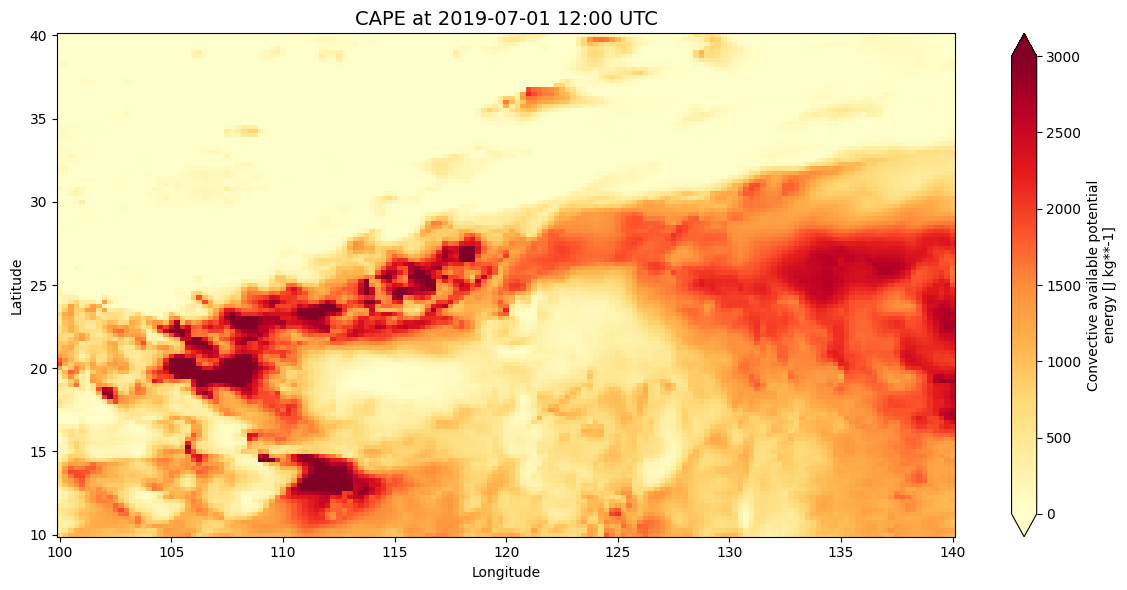

In [9]:
# 繪製 2019-07-01 12:00 的 CAPE 分布
cape_snapshot = ds['convective_available_potential_energy'].sel(time='2019-07-01 12:00')

plt.figure(figsize=(12, 6))
cape_snapshot.plot(cmap='YlOrRd', vmin=0, vmax=3000)
plt.title('CAPE at 2019-07-01 12:00 UTC', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

## 7. 檢查資料的 Chunk 資訊

理解 chunking 對於優化效能非常重要。

In [10]:
# 檢視 CAPE 的 chunk 結構
cape = ds['convective_available_potential_energy']

print("=== Chunk Information ===")
print(f"Original shape: {cape.shape}")
print(f"Chunk shape: {cape.chunks}")
print(f"Number of chunks: {cape.data.npartitions}")
print()

# 計算每個 chunk 的大小
chunk_size_mb = (744 * 121 * 161 * 4) / (1024**2)  # float32 = 4 bytes
print(f"Single chunk size: {chunk_size_mb:.2f} MB")
print(f"Total size: {cape.nbytes / (1024**3):.2f} GB")
print()

print("=== Chunking Strategy ===")
print("時間維度 chunk=744: 約一個月的資料")
print("空間維度不切分: 保持完整的 2D 空間場")
print("優勢: 適合時間序列分析和空間統計")

=== Chunk Information ===
Original shape: (8760, 121, 161)
Chunk shape: ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Chunking 的重要性

Chunk size 影響：
1. **太小** (< 10 MB)：overhead 過高，排程成本大於計算成本
2. **太大** (> 100 MB)：無法有效平行化，記憶體壓力大
3. **理想範圍**：10-100 MB per chunk

我們的 chunking（時間=744, 空間=全域）適合：
- ✅ 計算時間平均、標準差
- ✅ 空間插值、gradient 計算
- ❌ 單點時間序列分析（需要跨多個 chunks）

如果分析模式改變，可能需要 rechunk（我們會在 Notebook 2 討論）。

## 8. 檢查點：你應該理解的概念

完成這個 notebook 後，你應該能夠：

- [ ] 啟動 Dask Client 並使用 Dashboard 監控
- [ ] 解釋 Zarr 相對於 NetCDF 的優勢
- [ ] 使用 intake catalog 管理資料來源
- [ ] 區分 lazy 和 eager 操作
- [ ] 使用 `.sel()` 和 `.isel()` 進行索引
- [ ] 理解 chunk 對效能的影響
- [ ] 在需要時用 `.compute()` 觸發實際計算

### 常見錯誤與除錯

1. **記憶體不足 (OOM)**
   - 原因：一次 `.compute()` 太多資料
   - 解法：先用 `.sel()` 縮小範圍，或調整 `memory_limit`

2. **計算很慢**
   - 檢查 Dashboard 的 Task Stream
   - 如果大部分時間是紅色 (I/O)：可能 chunk 太小，考慮 rechunk
   - 如果是灰色 (idle)：worker 不足，增加 `n_workers`

3. **Dask Dashboard 打不開**
   - 確認 port 8787 沒有被佔用
   - 如果是 remote server，需要 port forwarding

## 9. 小練習（可選）

嘗試以下操作來熟悉工具：

1. **載入 2020 年資料**，計算全年的 K-index 平均
2. **選取香港附近** (22.3°N, 114.2°E) 的時間序列，繪製 CAPE 變化
3. **比較夏季與冬季**的 BLH（boundary layer height）空間分布
4. **觀察 Dashboard**：執行一個大範圍的統計計算，看 Task Stream 的變化

這些練習會幫助你熟悉 lazy evaluation 的思維模式。

## 下一步

在 **Notebook 2** 中，我們會學習：
- 時空 resampling（hourly → daily）
- 讀取多個年份的資料（2019-2023）
- 計算氣候態（climatology）
- 最佳化 chunking 並儲存為 Zarr

這些技巧會為後續的 ML pipeline 打下基礎。

In [11]:
# 關閉 Dask Client（釋放資源）
# 如果要繼續使用，可以不關閉
client.close()